# Cricket Player Classification

### Importing Libraries

In [64]:
import cv2
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [65]:
# Test image to see Dimensions
img = cv2.imread('./test_images/Mahrendra-Singh-Dhoni_may1.jpg')
img.shape

(900, 1200, 3)

Here x-axis= 900 and y-axis=1200 that is size of the image whereas 3 is RGB channels, as any colour can be represented using RGB

## Data cleaning

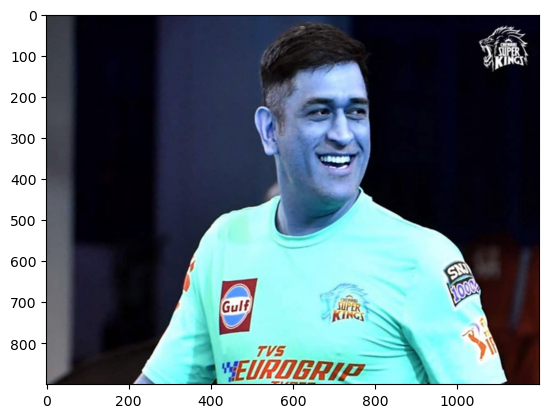

In [66]:
# show Image
plt.imshow(img)

This is the image that has RGB values. Now lets check image without RGB

In [67]:
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(900, 1200)

So we can see that there is no 3rd dimension

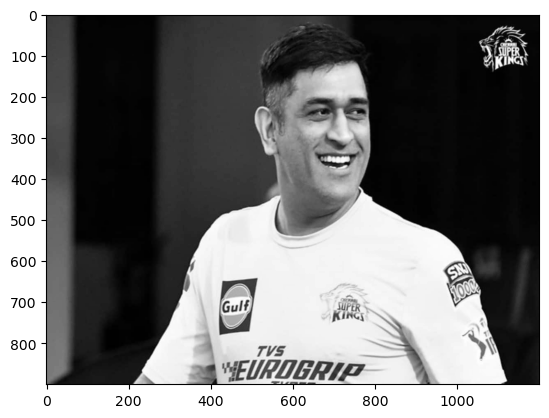

In [68]:
plt.imshow(gray, cmap="gray")

### Detecting Face and Eyes using Haarcascade

In [69]:
# Face
face_cascade= cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[560, 128, 285, 285]])

In [70]:
# Detecting Face
(a,b,c,d) = faces[0]
a,b,c,d

(560, 128, 285, 285)

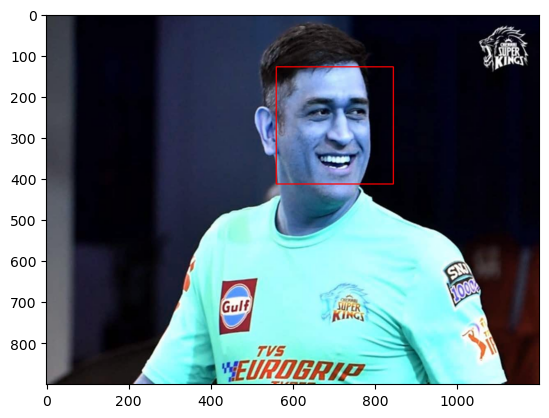

In [71]:
face_img= cv2.rectangle(img, (a,b),(a+c,b+d),(255,0,0),2)
plt.imshow(face_img)

In [72]:
# Eyes
eye_cascade= cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
eyes=eye_cascade.detectMultiScale(gray, 1.3, 5)

In [73]:
# Detecting Eyes
(ea,eb,ec,ed) = eyes[0]
ea,eb,ec,ed

(638, 206, 65, 65)

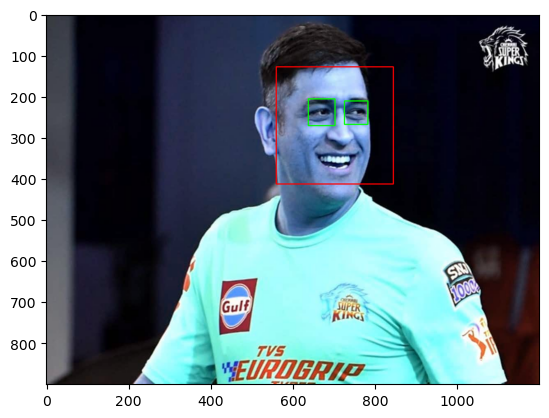

In [74]:
for (ea,eb,ec,ed) in eyes:
    eye_img = cv2.rectangle(img, (ea,eb),(ea+ec,eb+ed),(0,255,0),2)

plt.imshow(eye_img)

Lets get only cropped face

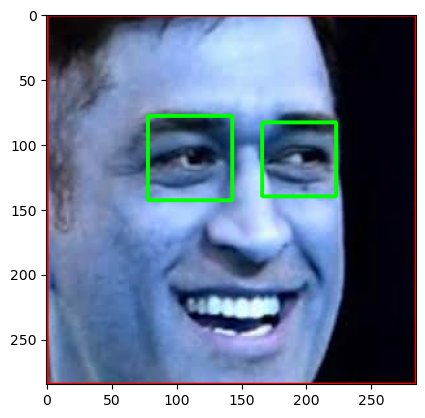

In [75]:
# roi is Region of interest
roi_color= face_img[b:b+d, a:a+c]
plt.imshow(roi_color, cmap='gray')

In [76]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3,5)
    for (a,b,c,d) in faces:
        roi_gray = gray[b:b+d, a:a+c]
        roi_color = img[b:b+d, a:a+c]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    

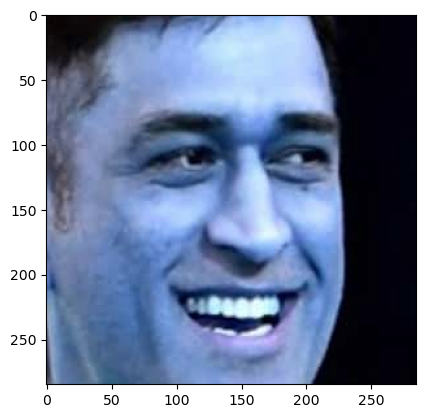

In [77]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Mahrendra-Singh-Dhoni_may1.jpg')
plt.imshow(cropped_image)

## Testing on a image that has no eyes

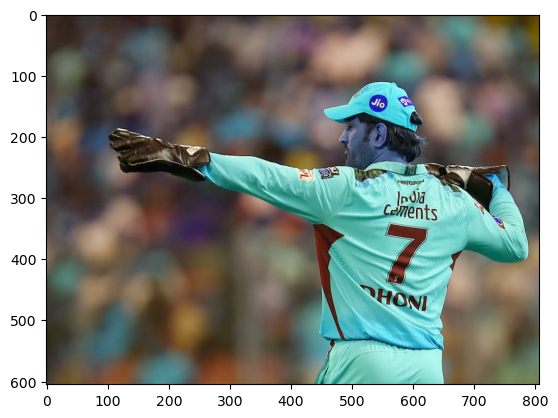

In [78]:
org_image_obstructed = cv2.imread('./test_images/utk3bmj8_ms-dhoni-csk-bcci_625x300_11_July_23.jpg')
plt.imshow(org_image_obstructed)

In [79]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/utk3bmj8_ms-dhoni-csk-bcci_625x300_11_July_23.jpg')
cropped_image_no_2_eyes

We can see here that there is no output so that means image has no clear eyes and face

### Creating a folder of cropped dataset

In [165]:
path_to_data = "./dataset/"
path_to_cropped_images = "./dataset/cropped/"

In [166]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [167]:
img_dirs

['./dataset/hardik_pandya',
 './dataset/kl_rahul',
 './dataset/ms_dhoni',
 './dataset/ravindra_jadeja']

In [172]:
img_dir

'./dataset/ravindra_jadeja'

In [169]:
import shutil
if os.path.exists(path_to_cropped_images):
    shutil.rmtree(path_to_cropped_images)
os.mkdir(path_to_cropped_images)

In [170]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)

hardik_pandya
kl_rahul
ms_dhoni
ravindra_jadeja


In [171]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cropped_images + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/hardik_pandya
Generating cropped images in folder:  ./dataset/cropped/kl_rahul
Generating cropped images in folder:  ./dataset/cropped/ms_dhoni
Generating cropped images in folder:  ./dataset/cropped/ravindra_jadeja


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## This is how it looks now

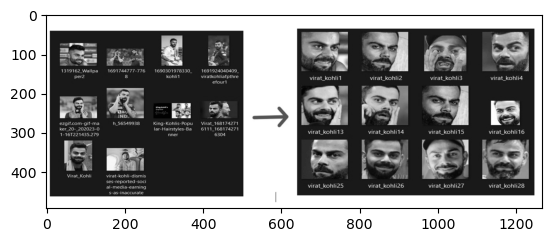

In [129]:
before_after_image = cv2.imread('./beforeafter/before_after.jpg').astype('float32')
gray= cv2.cvtColor(before_after_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

## Wavelet Transformation

In [152]:
def w2d(img, mode='haar', level= 1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    #process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *=0;
    
    #reconstruction 
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *=255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

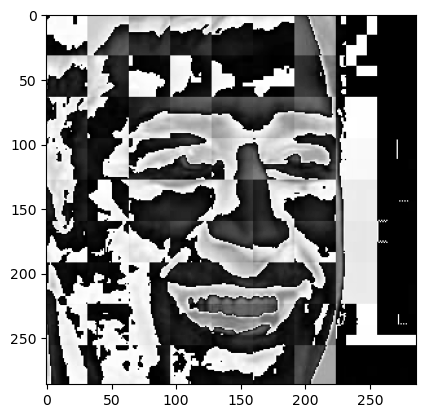

In [153]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

This image is very crucial for machine for recognition.

In [173]:
celebrity_file_names_dict

{'hardik_pandya': ['./dataset/cropped/hardik_pandya/hardik_pandya1.png',
  './dataset/cropped/hardik_pandya/hardik_pandya2.png',
  './dataset/cropped/hardik_pandya/hardik_pandya3.png',
  './dataset/cropped/hardik_pandya/hardik_pandya4.png',
  './dataset/cropped/hardik_pandya/hardik_pandya5.png',
  './dataset/cropped/hardik_pandya/hardik_pandya6.png',
  './dataset/cropped/hardik_pandya/hardik_pandya7.png',
  './dataset/cropped/hardik_pandya/hardik_pandya8.png',
  './dataset/cropped/hardik_pandya/hardik_pandya9.png',
  './dataset/cropped/hardik_pandya/hardik_pandya10.png',
  './dataset/cropped/hardik_pandya/hardik_pandya11.png',
  './dataset/cropped/hardik_pandya/hardik_pandya12.png',
  './dataset/cropped/hardik_pandya/hardik_pandya13.png',
  './dataset/cropped/hardik_pandya/hardik_pandya14.png',
  './dataset/cropped/hardik_pandya/hardik_pandya15.png',
  './dataset/cropped/hardik_pandya/hardik_pandya16.png',
  './dataset/cropped/hardik_pandya/hardik_pandya17.png',
  './dataset/cropped/ha

### We are going to use cropped images for model training. We will use these raw images along with wavelet transformed images to train our classifier. 

## Let's prepare X and y now

In [211]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'hardik_pandya': 0, 'kl_rahul': 1, 'ms_dhoni': 2, 'ravindra_jadeja': 3}

In [212]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [213]:
len(X)

94

In [214]:
len(X[0])

4096

In [215]:
y[0]

0

In [216]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(94, 4096)

In [217]:
X[0]

array([189., 212., 238., ...,  36.,  19.,  86.])

Here we have defined Independant variable (X) and Dependant Variable (y) 

## Model Training

### 1. Support Vector Machines

In [218]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

Train Test Split

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [220]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

We got 75% accuracy

In [221]:
len(X_test)

24

We have tested model on 24 samples only

In [210]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67         6
           2       0.83      0.71      0.77         7
           3       0.00      0.00      0.00         1

    accuracy                           0.75        24
   macro avg       0.62      0.55      0.56        24
weighted avg       0.77      0.75      0.72        24



## 2. GridSearchCV

In [222]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [223]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [224]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.485714,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.528571,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.557143,{'logisticregression__C': 1}


In [225]:
best_estimators['svm'].score(X_test,y_test)

0.75

In [226]:
best_estimators['random_forest'].score(X_test,y_test)

0.6666666666666666

In [227]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6666666666666666

In [230]:
best_clf = best_estimators['svm']

In [231]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[9, 0, 1, 0],
       [2, 4, 0, 0],
       [1, 1, 5, 0],
       [1, 0, 0, 0]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

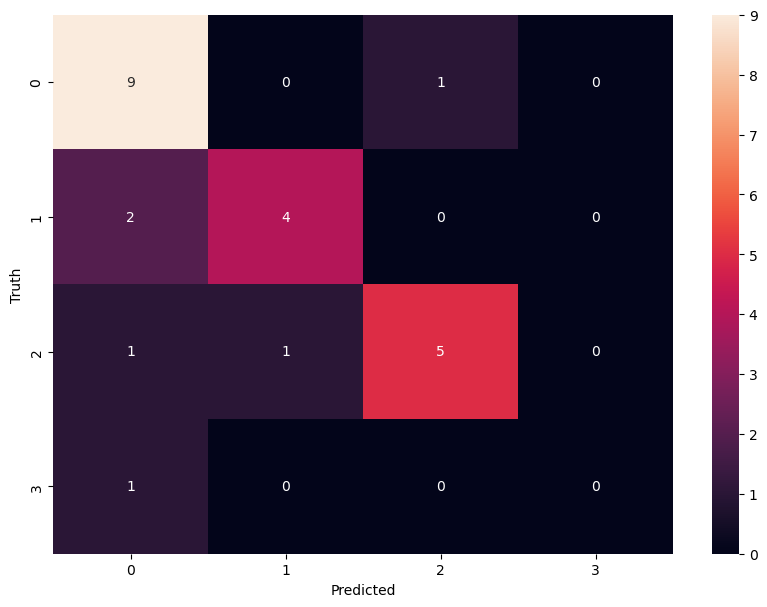

In [232]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [233]:
class_dict

{'hardik_pandya': 0, 'kl_rahul': 1, 'ms_dhoni': 2, 'ravindra_jadeja': 3}

We can see that SVM gives us the best accuracy so lets use SVM for dployment

### Saving model in pickle file

In [234]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Saving Class dictionary

In [235]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))